Training size: 4200
Testing size: 1800
Epoch 1/10, Loss: 0.9443, Accuracy: 0.5481
Epoch 2/10, Loss: 0.7298, Accuracy: 0.6829
Epoch 3/10, Loss: 0.6598, Accuracy: 0.7121
Epoch 4/10, Loss: 0.6310, Accuracy: 0.7240
Epoch 5/10, Loss: 0.6379, Accuracy: 0.7302
Epoch 6/10, Loss: 0.6054, Accuracy: 0.7367
Epoch 7/10, Loss: 0.6095, Accuracy: 0.7410
Epoch 8/10, Loss: 0.6006, Accuracy: 0.7469
Epoch 9/10, Loss: 0.6129, Accuracy: 0.7445
Epoch 10/10, Loss: 0.5867, Accuracy: 0.7567


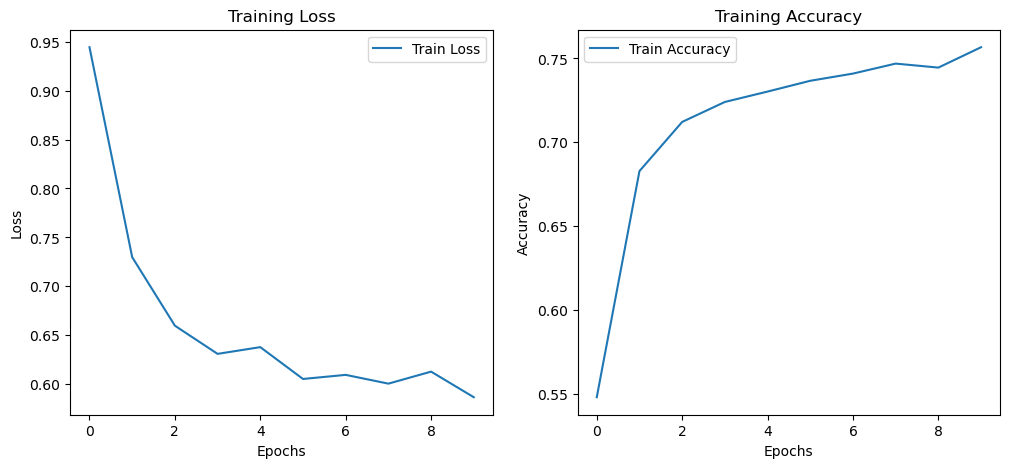

Unique labels in feature_labels: [0 1 2]
Labels list: [1 1 1 ... 2 2 0]
Output shape from the model: (1800, 3)


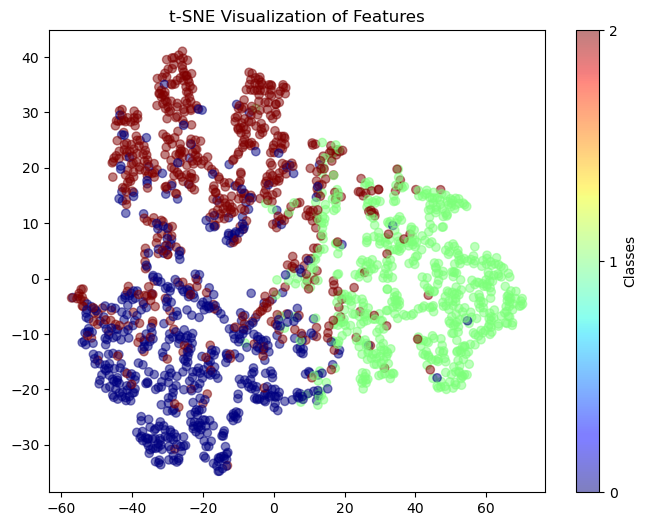

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


os.environ["LOKY_MAX_CPU_COUNT"] = "None"
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


data_dir = './Dataset 1/Colorectal Cancer' 
dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

# Split dataset into 70% training, 30% testing
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


print(f"Training size: {train_size}")
print(f"Testing size: {test_size}")


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN Model (ResNet18) with added Dropout
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)


model.fc = nn.Sequential(
    nn.Dropout(0.5),  
    nn.Linear(model.fc.in_features, 3)  
)
model = model.to(device)


for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


num_epochs = 10  
train_loss_history, train_acc_history = [], []

for epoch in range(num_epochs):
    if epoch == 5:
        for name, param in model.named_parameters():
            if "layer4" in name:  
                param.requires_grad = True

    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    scheduler.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

# Plot training accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label="Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.show()

def extract_features(model, dataloader):
    model.eval()
    features, labels = [], []
    
    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs) 
            features.append(outputs.cpu().numpy())
            labels.append(lbls.cpu().numpy())
    
    return np.concatenate(features), np.concatenate(labels)


features, feature_labels = extract_features(model, test_loader)
labels_list = feature_labels.astype(int)  
print("Unique labels in feature_labels:", np.unique(feature_labels))
print("Labels list:", labels_list)


scaler = StandardScaler()  
features_scaled = scaler.fit_transform(features)  
tsne = TSNE(n_components=2, perplexity=30, random_state=42)  
features_tsne = tsne.fit_transform(features_scaled)
print("Output shape from the model:", features.shape)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels_list, cmap="jet", alpha=0.5)
plt.colorbar(scatter, ticks=np.unique(labels_list), label="Classes")  # Correct color mapping
plt.title("t-SNE Visualization of Features")
plt.show()
